# Final Project

In general, the contents of this notebook would be as follows:

1. Data preprocessing
2. Model benchmark and metric evaluation
3. Hyperparameter tuning for the model benchmark
4. Feature importance
5. Model deployment

# Data Preprocessing

In [1]:
# Import libraries

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler  

# Save Model
import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
bank = pd.read_csv('bank.csv')

## Outliers Analysis

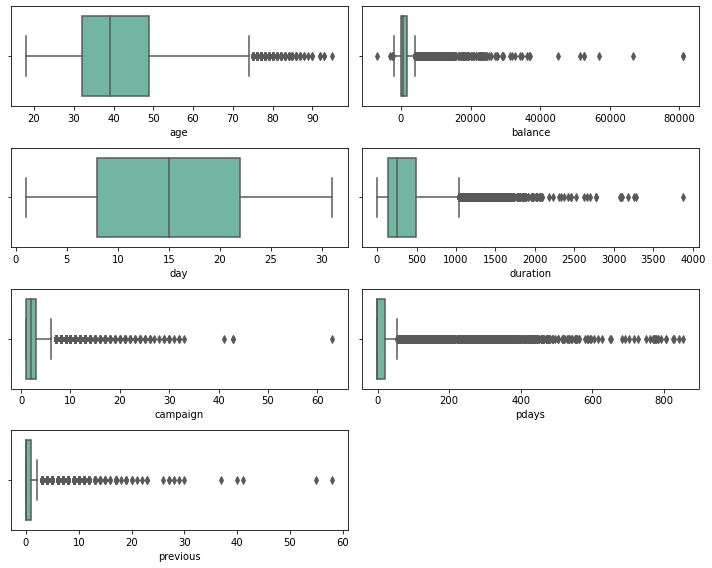

In [3]:
# Checking outliers in continuous variable
features = [feature for feature in bank.columns if ((bank[feature].dtypes != 'O'))]
n = 1

plt.figure(figsize=(10, 8))
for feature in features:
    plt.subplot(4, 2, n)
    sns.boxplot(bank[feature], palette='Set2')
    n+=1
    plt.tight_layout();

In [4]:
# Create a function to identify outliers
from numpy import percentile

def outliers():
    features = [feature for feature in bank.columns if ((bank[feature].dtypes != 'O'))]
    
    for i in features:
        # calculate interquartile range
        q25, q75 = percentile(bank[i], 25), percentile(bank[i], 75)
        iqr = q75 - q25
        print(f'Percentiles {i}: \n 25th = {q25} \n 75th = {q75} \n IQR = {iqr}')

        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off

        # identify outliers
        outliers = [x for x in bank[i] if x < lower or x > upper]
        print(f'Identified outliers in {i}: {len(outliers)}')
        print()

In [5]:
# Check outliers identification result
outliers()

Percentiles age: 
 25th = 32.0 
 75th = 49.0 
 IQR = 17.0
Identified outliers in age: 171

Percentiles balance: 
 25th = 122.0 
 75th = 1708.0 
 IQR = 1586.0
Identified outliers in balance: 1055

Percentiles day: 
 25th = 8.0 
 75th = 22.0 
 IQR = 14.0
Identified outliers in day: 0

Percentiles duration: 
 25th = 138.0 
 75th = 496.0 
 IQR = 358.0
Identified outliers in duration: 636

Percentiles campaign: 
 25th = 1.0 
 75th = 3.0 
 IQR = 2.0
Identified outliers in campaign: 601

Percentiles pdays: 
 25th = -1.0 
 75th = 20.75 
 IQR = 21.75
Identified outliers in pdays: 2750

Percentiles previous: 
 25th = 0.0 
 75th = 1.0 
 IQR = 1.0
Identified outliers in previous: 1258



## Feature Selection

In [6]:
# Checking 20 data with the largest campaign value in descending order
bank.nlargest(20, 'campaign')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
7635,45,management,married,unknown,no,9051,yes,no,unknown,19,may,124,63,-1,0,unknown,no
6927,51,blue-collar,married,unknown,no,41,yes,no,telephone,9,jul,16,43,-1,0,unknown,no
7240,33,blue-collar,married,secondary,no,0,yes,yes,cellular,31,jul,16,43,-1,0,unknown,no
7139,42,blue-collar,married,primary,no,170,yes,no,unknown,19,may,51,41,-1,0,unknown,no
9683,49,services,divorced,secondary,no,933,no,yes,cellular,29,jul,92,33,-1,0,unknown,no
4912,50,entrepreneur,married,primary,no,461,yes,no,unknown,15,may,651,32,-1,0,unknown,yes
7237,42,self-employed,married,tertiary,no,1932,yes,no,unknown,16,may,192,32,-1,0,unknown,no
10293,31,services,married,unknown,no,-82,yes,no,cellular,31,jul,543,31,-1,0,unknown,no
7763,44,services,divorced,secondary,no,608,yes,yes,unknown,18,jun,19,30,-1,0,unknown,no
10865,51,services,married,secondary,no,7,yes,no,cellular,31,jul,8,30,-1,0,unknown,no


According to the data above, it can be seen that all the potential customers have never been contacted in the previous campaign. I can assume that possibly in the current campaign, the Portuguese bank wanted to take an aggressive approach to fresh leads. Therefore, I decided not to throw out any samples. In other words, firstly, I will build a benchmark model without outliers removal and with some feature engineering methods. 

In [7]:
# Create a copy of original data variable
df = bank.copy()

The current task is related to filtering the columns that will not be used on a predictive model. Since this dataset does not have any key-columns that do not make sense to include on a machine learning model, the only column to be dropped is 'duration'. Even though this variable is the most correlated one with the target label, the drop must be done because it denotes the last call duration with the customer during the term deposit offer. Hence, the duration values are known only after the contact has been made and finished. Not only that, dropping the duration feature is one way to avoid data leakage since this feature contains future information that is not needed in predicting.

In addition to the above reasons, this project's objective is to build a predictive model that is capable of predicting the chance of a potential customer subscribing to a term deposit before the contact is made. 

In [8]:
# Drop 'duration' feature
df = df.drop(['duration'], axis=1)

### Data Manipulation

Features that need to be transformed for modeling:

1. Transforming the 'day' feature into week groups (week 1 to week 4) will prevent 31 different encoding variables and generalize the variable. Thus, it will make more sense to the business problem at hand.

2. In the 'pdays' feature, the value of -1 means the potential client was never contacted. Since a value of -1 does not make sense in this field and will not properly capture that a potential client has never been contacted, it is better to replace the -1 value with 0 and make the other numbers in this feature into 1 (transforming into a binary variable).

3. Create a new label for the target variable that consists of 0 and 1, so the machine learning model can work with it.

In [9]:
# Transforming the 'day' feature into week groups
week_group = []

for i in df['day']:
    if i <= 7:
        week_group.append('w1')
    elif i > 7 and i <= 14:
        week_group.append('w2')
    elif i > 14 and i <= 21:
        week_group.append('w3')
    else:
        week_group.append('w4')

df['day'] = week_group

In [10]:
# Create a function to transform pdays into a binary variable
# Assuming that 0 means never been contacted and 1 means been contacted in the previous campaign
def pdays_group(pdays):
    if(pdays == -1):
        return (0)
    elif(pdays >= 0):
        return (1)

df['pdays'] = df['pdays'].apply(pdays_group)

In [11]:
# Create a new target label that consists of 0 and 1
# 0 = 'no' and 1 = 'yes'

df['label'] = np.where(df['deposit'] == 'yes', 1, 0)

In [12]:
# Check the current dataframe
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,label
0,59,admin.,married,secondary,no,2343,yes,no,unknown,w1,may,1,0,0,unknown,yes,1
1,56,admin.,married,secondary,no,45,no,no,unknown,w1,may,1,0,0,unknown,yes,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,w1,may,1,0,0,unknown,yes,1
3,55,services,married,secondary,no,2476,yes,no,unknown,w1,may,1,0,0,unknown,yes,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,w1,may,2,0,0,unknown,yes,1


### Transformer Pipeline

In [13]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  object
 10  month      11162 non-null  object
 11  campaign   11162 non-null  int64 
 12  pdays      11162 non-null  int64 
 13  previous   11162 non-null  int64 
 14  poutcome   11162 non-null  object
 15  deposit    11162 non-null  object
 16  label      11162 non-null  int32 
dtypes: int32(1), int64(5), object(11)
memory usage: 1.4+ MB


Encoding scheme:

1. age: passthrough
2. job: binary encoding
3. marital: one-hot encoding
4. education: one-hot encoding
5. default: one-hot encoding
6. balance: passthrough
7. housing: one-hot encoding
8. loan: one-hot encoding
9. contact: one-hot encoding
10. day: one-hot encoding
11. month: binary encoding
12. campaign: passthrough
13. pdays: passthrough
14. previous: passthrough
15. poutcome: one-hot encoding

Features that need to be encoded first are:

    - job           - loan
    - marital       - contact
    - education     - day
    - default       - month
    - housing       - poutcome
    

The next following step is to create a transformer pipeline by including encoding methods that have been chosen for each feature. In this project, I would like to try several classifier models, which are:

    1. Logistic Regression
    2. KNN
    3. Decision Tree 
    4. Random Forest
    5. AdaBoostClassifier
    6. GradientBoostingClassifier
    7. XGBoostingClassifier

Since Logistic Regression and KNN models are sensitive to the value of data points, I need to scale 2 numerical features that still have a wide range of values (age and balance). By creating two transformers, I will compare the cross-validation results between normal and scaled data. 

In [14]:
# Create a transformer
transformer = ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'), ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'poutcome']),
    ('binary encoder', ce.BinaryEncoder(), ['job', 'month'])
], remainder='passthrough')

# Create a transformer for scaling
transformer_scaled = ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'), ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'poutcome']),
    ('binary encoder', ce.BinaryEncoder(), ['job', 'month']),
    ('scaling', RobustScaler(), ['age', 'balance'])
], remainder='passthrough')

In [15]:
# Fitting transforming transformer 
transformer.fit_transform(df)

array([[1.0, 0.0, 1.0, ..., 0, 'yes', 1],
       [1.0, 0.0, 1.0, ..., 0, 'yes', 1],
       [1.0, 0.0, 1.0, ..., 0, 'yes', 1],
       ...,
       [0.0, 1.0, 1.0, ..., 0, 'no', 0],
       [1.0, 0.0, 1.0, ..., 5, 'no', 0],
       [1.0, 0.0, 1.0, ..., 0, 'no', 0]], dtype=object)

In [16]:
# Fitting transforming transformer_scaled
transformer_scaled.fit_transform(df)

array([[1.0, 0.0, 1.0, ..., 0, 'yes', 1],
       [1.0, 0.0, 1.0, ..., 0, 'yes', 1],
       [1.0, 0.0, 1.0, ..., 0, 'yes', 1],
       ...,
       [0.0, 1.0, 1.0, ..., 0, 'no', 0],
       [1.0, 0.0, 1.0, ..., 5, 'no', 0],
       [1.0, 0.0, 1.0, ..., 0, 'no', 0]], dtype=object)

## Model Benchmark & Evaluation Metric

To yield a model benchmark, splitting the data needs to be done to prevent data leakage.

Evaluation metric:

> I choose 'precision' for the evaluation metric because I need to know how well the model predicts the positive class. If it is     tailored to the business problem, I aim to make a model capable of giving the best prediction of potential customers that most likely will subscribe to a term deposit. From that point, telemarketers then will only approach the targeted and selected potential customers. Thus, the marketing activity effectiveness is feasible to achieve.

### Data Splitting

In [17]:
# Splitting data into X and y
X = df.drop(columns = ['deposit', 'label'])
y = df[['label']]

In [18]:
# Create a train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.2,
    stratify = y,
    random_state = 2021)

### Cross validation for choosing model benchmark

Without scaling

In [19]:
# Create a models variable that consists of models that will be used
models = [
    ['Logistic Regression', LogisticRegression(random_state=2021)],
    ['KNN', KNeighborsClassifier()],
    ['Decision Tree', DecisionTreeClassifier(random_state=2021)],
    ['Random Forest', RandomForestClassifier(random_state=2021)],
    ['AdaBoostClassifier', AdaBoostClassifier(random_state=2021)],
    ['GradientBoosing', GradientBoostingClassifier(random_state=2021)],
    ['XGBC', XGBClassifier(random_state=2021, verbosity=0)]
]

In [20]:
# Create a function for cross validation
def evaluate(models):
    model_name = []
    precision_score = []
    precision_std = []

    for name, model in models:
        estimator = Pipeline([('preprocess', transformer), ('model', model)])

        skfold = StratifiedKFold(n_splits=5)

        model_name.append(name)
        precision_score.append(cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision').mean())
        precision_std.append(cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision').std())

    return pd.DataFrame({
        'model': model_name,
        'precision_score': precision_score,
        'precision_std': precision_std
        })

In [21]:
# Check models evaluation
evaluate(models)

,model,precision_score,precision_std
0,Logistic Regression,0.676998,0.017246
1,KNN,0.559099,0.012152
2,Decision Tree,0.598975,0.009598
3,Random Forest,0.728061,0.007480
4,AdaBoostClassifier,0.710435,0.014565
5,GradientBoosing,0.754974,0.018727
6,XGBC,0.723067,0.019728


With scaling (RobustScaler)

In [22]:
# Create a function for cross validation
def evaluate(models):
    model_name = []
    precision_score = []
    precision_std = []

    for name, model in models:
        estimator = Pipeline([('preprocess', transformer_scaled), ('model', model)])

        skfold = StratifiedKFold(n_splits=5)

        model_name.append(name)
        precision_score.append(cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision').mean())
        precision_std.append(cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='precision').std())

    return pd.DataFrame({
        'model': model_name,
        'precision_score': precision_score,
        'precision_std': precision_std
        })

In [23]:
# Check models evaluation
evaluate(models)

,model,precision_score,precision_std
0,Logistic Regression,0.702177,0.019292
1,KNN,0.664598,0.005618
2,Decision Tree,0.599003,0.009416
3,Random Forest,0.727602,0.007575
4,AdaBoostClassifier,0.710435,0.014565
5,GradientBoosing,0.755186,0.018487
6,XGBC,0.723172,0.020062


Key takeaways:

> According to the comparison between normal and scaled data to the chosen models, it is expected that the Logistic Regression and KNN models have improved significantly in their precision score. On the other hand, since tree-based models, including ensemble models, are not sensitive to the data's variance, their results are not significantly improved.

> GradienBoostingClassifier always has the highest precision score and relatively stable in the evaluation of normal and scaled data. Even though the precision score of scaled data is slightly better, but I will choose the GradienBoostingClassifier model without data scaling for the model benchmark. This considers that GradienBoostingClassifier with scaled data will take up the computation time longer than it should be.

In [24]:
# Check model benchmark performance against test data
estimator = Pipeline([('preprocess', transformer), ('model', GradientBoostingClassifier())])
estimator.fit(X_train, y_train)
precision_gbc = precision_score(y_test, estimator.predict(X_test))
precision_gbc

0.754257907542579

### Hyperparameter Tuning

Benchmark model before tuning

In [25]:
# Check the classification report of benchmark model before tuning
model = GradientBoostingClassifier()

estimator_gbc = Pipeline([('transformer', transformer), ('model', model)])
estimator_gbc.fit(X_train, y_train)

y_pred = estimator_gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1175
           1       0.75      0.59      0.66      1058

    accuracy                           0.71      2233
   macro avg       0.72      0.71      0.71      2233
weighted avg       0.72      0.71      0.71      2233



In [26]:
# Create a label for confusion matrix plot
labels = ['Not Subscribed', 'Subscribed']

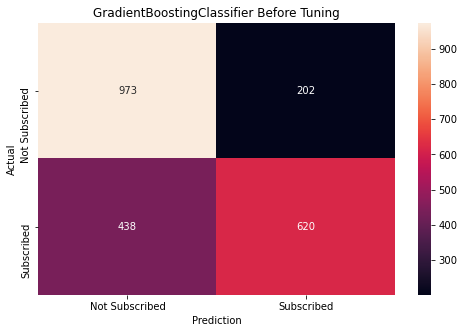

In [27]:
# Confusion matrix of GBC before tuning
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.title('GradientBoostingClassifier Before Tuning')
plt.xlabel('Prediction')
plt.ylabel('Actual');

Benchmark model after tuning

In [28]:
# Tuning parameters for GradientBoostingClassifier
hyperparam_space = {
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators': [50, 75, 100, 150],
        'model__min_samples_leaf': [1, 5, 10, 15, 20, 50],
        'model__min_samples_split': [2, 5, 10, 15, 20, 50],
        'model__max_depth': [2, 3, 4, 5, 6, 7],
        'model__max_features': ['sqrt']}

In [29]:
# Grid search to find the best params
estimator = Pipeline([('preprocess', transformer), ('model', GradientBoostingClassifier(random_state=2021))])
skfold = StratifiedKFold(n_splits=5)

grid_gbc = GridSearchCV(
    estimator, 
    param_grid = hyperparam_space, 
    cv = skfold, 
    scoring = 'precision',
    n_jobs = -1)

grid_gbc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
              

In [30]:
# Grid best params
grid_gbc.best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 6,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

In [31]:
# Grid best score
grid_gbc.best_score_

0.774685143803665

In [32]:
# Evaluate the best estimator to the test data
grid_gbc.best_estimator_.fit(X_train, y_train)
precision_gbc_tuning = precision_score(y_test, grid_gbc.best_estimator_.predict(X_test))
precision_gbc_tuning

0.761501210653753

In [33]:
# Create y prediction variable
y_pred = grid_gbc.best_estimator_.predict(X_test)

In [34]:
# Check classification report after tuning
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1175
           1       0.76      0.59      0.67      1058

    accuracy                           0.72      2233
   macro avg       0.73      0.71      0.71      2233
weighted avg       0.73      0.72      0.71      2233



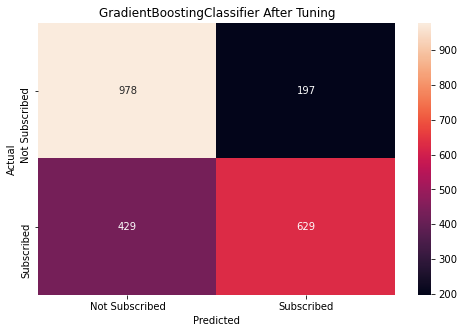

In [35]:
# Confusion matrix plot after tuning
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.title('GradientBoostingClassifier After Tuning')
plt.xlabel('Predicted')
plt.ylabel('Actual');

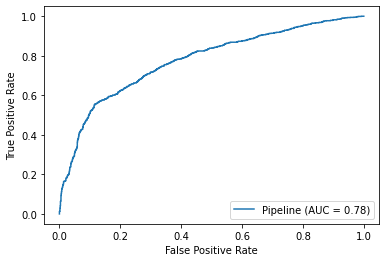

In [36]:
# Plot ROC curve
plot_roc_curve(grid_gbc.best_estimator_, X_test, y_test);

In [37]:
# Create a summary table of precision scores
title = ['GBC Before Tuning', 'GBC After Tuning']
function = [precision_gbc, precision_gbc_tuning]

summary = pd.DataFrame(
    {'Method': title,
    'Precision Score': function}
)

summary

,Method,Precision Score
0,GBC Before Tuning,0.754258
1,GBC After Tuning,0.761501


Summary:

> 1. The best model for this project case is the GradientBoostingClassifier with hyperparameters tuning, even though the precision score is increased slightly from 0.754 to 0.761. Improvement of the model outcome may be done by removing outliers, feature selection, adding parameters during tuning, or also try using other models.

> 2. In increasing marketing effectiveness, I may be far more concerned with having low false positives (FP) than low false negatives (FN). A false positive would mean contacting the potential customers who are not willing to subscribe in the first place, leading to wasting of time and effort. 

> 3. According to the confusion matrix of GradientBoostingClassifier after tuning, the amount of FP is 197. Calculating the false positive rate (FPR) that represents how often a positive class is predicted when the actual outcome is negative, the FPR of this model is 16.7%. It means that out of 100 people that the machine learning model predicts, only 16.7% or about 16 people that have been contacted by the telemarketers and refused to subscribe to a term deposit. Comparing to the GBC model without tuning, the FPR value is 17.1% which means around 17 out of 100 people will refuse to the offer. 

> 4. Since the dataset is balanced, I tried to plot the ROC curve to see the relation between true positve rate (TPR) and FPR. TPR means how good the model is at predicting the positive class when the actual outcome is also positive. The TPR value of the model is 59.4% and it means that this model can correctly predict about 59 out of 100 people that would like to subscribe to a term deposit.

### Feature Importance

In [38]:
# Create X train and X test preprocessed (after encoding)
X_train_preprocessed = transformer.fit_transform(X_train) 
X_test_preprocessed = transformer.transform(X_test)

In [39]:
# Define the selected model
model_gbc = GradientBoostingClassifier(
    n_estimators = 100,
    learning_rate = 0.05,
    max_depth = 6,
    max_features = 'sqrt',
    min_samples_leaf = 5,
    min_samples_split = 50,
    random_state = 2021
)

model_gbc.fit(X_train_preprocessed, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=50,
                           random_state=2021)

In [44]:
# Create new features variable
features = list(transformer.transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1].get_feature_names() + ['age', 'balance', 'campaign', 'pdays', 'previous']

In [45]:
# Create an importance table variable
importance_table = pd.DataFrame({
    'imp':model_gbc.feature_importances_
}, index = features)

importance_table

,imp
x0_married,0.017413
x0_single,0.013717
x1_secondary,0.003892
x1_tertiary,0.012245
x1_unknown,0.001908
x2_yes,0.002689
x3_yes,0.075072
x4_yes,0.019238
x5_telephone,0.007939
x5_unknown,0.111311


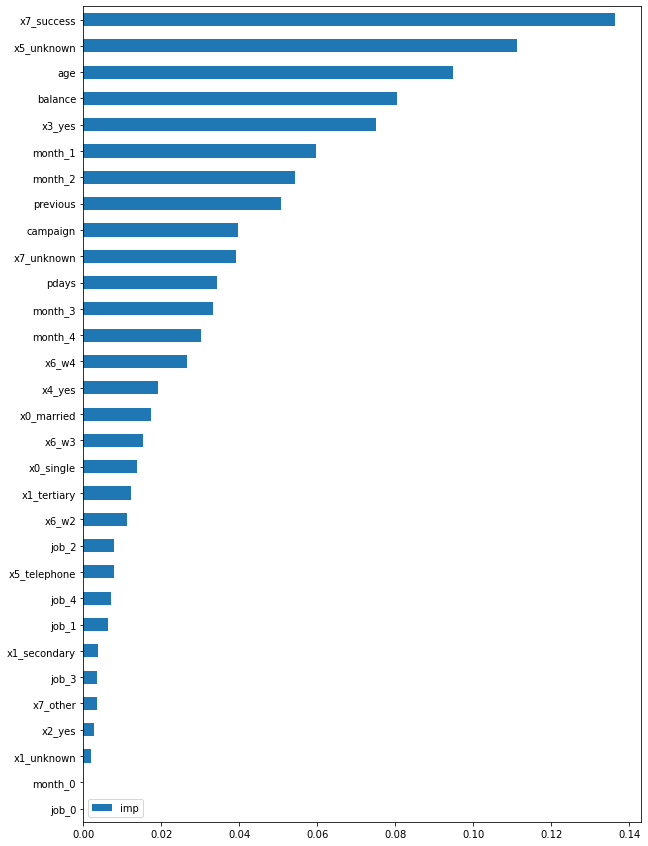

In [46]:
# Plot importance table
importance_table.sort_values(by = 'imp').plot(kind = 'barh', figsize = (10, 15));

### Recommendation to the management

According to the feature importance plot, the highly important features need to be used for the optimization model and the unimportant ones may be removed. Furthermore, the marketing manager should aware about the most important features that affecting the lead conversion rate. Those features are as follows:

Potential customer profile:

1. Age
2. Balance
3. Has a housing loan or not

Previous campaign information:

1. The result of the previous campaign
2. Type of contact  
3. The number of calls performed in the previous campaign

In addition to that information, the marketing manager also should consider the month of marketing campaign activity, considering this feature affects the success rate of the marketing campaign.

## Model Deployment

### Save Model

In [28]:
# Save model
estimator = Pipeline([('preprocess', transformer),('model', GradientBoostingClassifier())])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('Bank_Model.sav', 'wb'))

In [48]:
# Save tuning result
model_final = grid_gbc.best_estimator_.fit(X_train, y_train)

pickle.dump(model_final, open('Final_Tuning_Bank.sav', 'wb'))

### Load Model

In [29]:
# Load model
filename = 'Bank_Model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [30]:
loaded_model.predict(X_test)

array([0, 1, 0, ..., 0, 1, 0])

In [31]:
precision_score(y_test, loaded_model.predict(X_test))

0.754257907542579